In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Model testing

In [2]:
# Load model
model = tf.keras.models.load_model('D:/COPY/Projekt_FF/Process//UNet_forest')

In [3]:
# Load test DOP
filepath = 'D:/COPY/Projekt_FF/Process/dop_test_forestmask.nc'
dop_test = rxr.open_rasterio(filepath)
dop_test = dop_test.squeeze()
dop_test

<xarray.Dataset>
Dimensions:              (x: 10000, y: 10000)
Coordinates:
    band                 int32 1
  * x                    (x) float64 4.66e+05 4.66e+05 ... 4.67e+05 4.67e+05
  * y                    (y) float64 5.671e+06 5.671e+06 ... 5.67e+06 5.67e+06
    transverse_mercator  int32 0
    spatial_ref          int32 0
Data variables:
    Band1                (y, x) uint8 ...
    Band2                (y, x) uint8 ...
    Band3                (y, x) uint8 ...
    Band4                (y, x) uint8 ...
    forest_mask          (y, x) uint8 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Fri Nov 11 15:59:30 2022: GDAL CreateCopy( D:/COPY/Projekt_...

In [4]:
# Define tile size
tilesize = 224

In [5]:
# Define data generator for the model
# Tiles the dataset into multiple tiles and returns them in batches (row-wise)
# Also splits the data into training/validation/test
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ds, sampletype, tilesize=tilesize):
        self.ds   = ds
        self.ylen = self.ds.y.size // tilesize
        self.xlen = self.ds.x.size // tilesize
        self.sampletype = sampletype
        
    def __len__(self):
        return self.ylen

    def __getitem__(self, index):
        
        red       = self.ds.Band1[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        green     = self.ds.Band2[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        blue      = self.ds.Band3[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        forest    = self.ds.forest_mask[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        
        rgb       = np.array([red,green,blue]).transpose(1,2,0)
        forest    = np.array(forest)
        
        rgb_tiles    = np.array(np.split(rgb, self.xlen,axis=1))
        target_tiles = np.array(np.split(forest, self.xlen,axis=1))
        
        # Depending on sampletype, return training, validation or test set (complete set)
        if self.sampletype == 'training' or self.sampletype == 'validation':
            rgb_tiles_tr, rgb_tiles_val, target_tiles_tr, target_tiles_val = train_test_split(rgb_tiles, target_tiles, shuffle=True, test_size=0.1, random_state=0)
            if self.sampletype == 'training': return rgb_tiles_tr, target_tiles_tr
            else:                             return rgb_tiles_val, target_tiles_val
        
        if self.sampletype == 'test': return rgb_tiles, target_tiles
        
        return None

In [6]:
# Provide data generator with the test DOP
cidg_test   = CustomImageDataGenerator(dop_test, sampletype='test')

In [7]:
# Predict forest area
prediction = model.predict(cidg_test)

44/44 [==============================] - 75s 2s/step


In [8]:
print('number of tiles:', prediction.shape[0])
print('tilesize:', prediction.shape[1])
print('classes:', prediction.shape[3])

number of tiles: 1936
tilesize: 224
classes: 2


In [9]:
# Convert the array into a final forest/non-forest mask
pred_mask = np.argmax(prediction, axis=-1)
pred_mask.shape

(1936, 224, 224)

In [10]:
# Merge all tiles into the original DOP
xs = dop_test.x.size-dop_test.x.size%tilesize
ys = dop_test.y.size-dop_test.y.size%tilesize

x_cnt = dop_test.x.size // tilesize
y_cnt = dop_test.y.size // tilesize

final_result = np.concatenate([np.concatenate(pred_mask[i*x_cnt:(i+1)*x_cnt], axis=1) for i in range(y_cnt)], axis=0)

In [11]:
final_result

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int64)

Text(0.5, 1.0, 'Prediction of forest area')

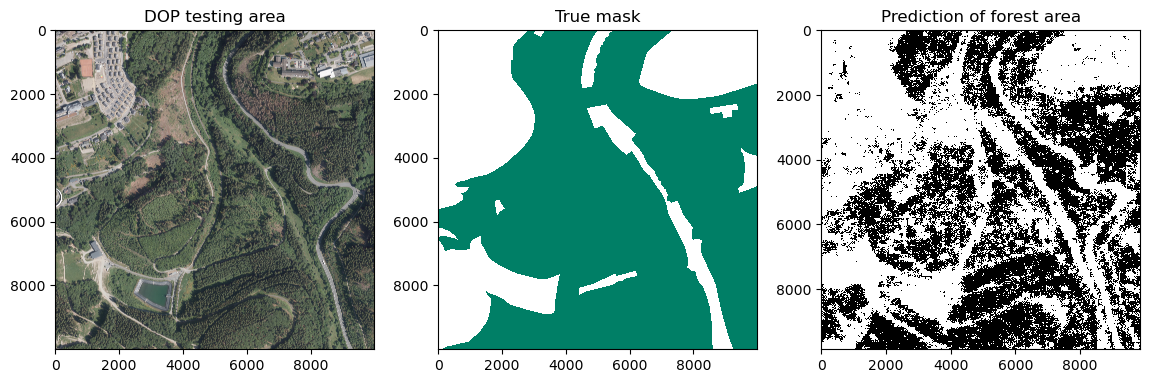

In [14]:
# Plot final prediction
fig, ax = plt.subplots(1,3, figsize=(14,10))
ax[0].imshow(np.array([dop_test.Band1, dop_test.Band2, dop_test.Band3]).transpose(1,2,0))
ax[0].set_title('DOP testing area')
ax[1].imshow(np.where(dop_test.forest_mask==1,1,np.nan), interpolation='None', cmap='summer')
ax[1].set_title('True mask')
ax[2].imshow(final_result, interpolation='None', cmap='Greys')
ax[2].set_title('Prediction of forest area')

In [15]:
y_rest = (dop_test.y.size%tilesize)
x_rest = (dop_test.x.size%tilesize)

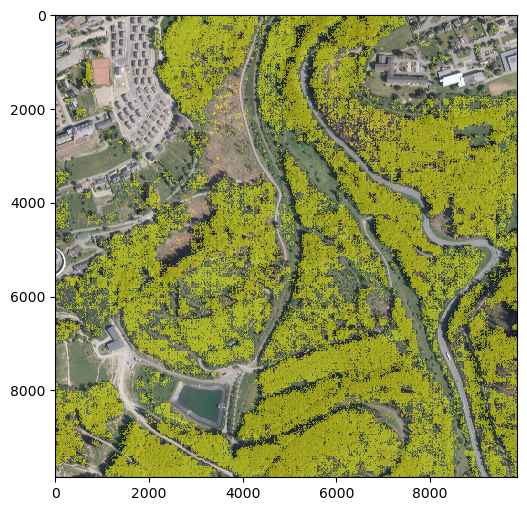

In [16]:
plt.figure(figsize=(10,6))
plt.imshow(np.array([dop_test.Band1[:-y_rest,:-x_rest],
                     dop_test.Band2[:-y_rest,:-x_rest],
                     dop_test.Band3[:-y_rest,:-x_rest]]).transpose(1,2,0))
plt.imshow(np.where(final_result==1,1,np.nan), cmap='autumn_r', interpolation='None', alpha=0.5)
plt.show()

In [ ]:
# Calculate statistical metrics
# Keras implementation of accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(final_result, dop_test.forest_mask[:-y_rest,:-x_rest])
print('Accuracy:', accuracy.result().numpy())

# MeanIoU (Image segmentation metrics)
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(final_result, dop_test.forest_mask[:-y_rest,:-x_rest])
print('MeanIoU:', mean_iou.result().numpy())